# FCNN versus CNN
This notebook is primarily concerned with recreating Figure 1 in **Why Are Convolutional Networks More Sample Efficient Than Fully-Connected Nets?** by Zhiyuan Li, Yi Zhang and Sanjeev Arora [1]. We have two lines of thought about this figure.

1. We wish to verify that the graphs are authentic and clarify their methods.
2. We believe that the graphs don't reflect the sample-complexity gap claimed in the abstract.

This notebook will address point 1.

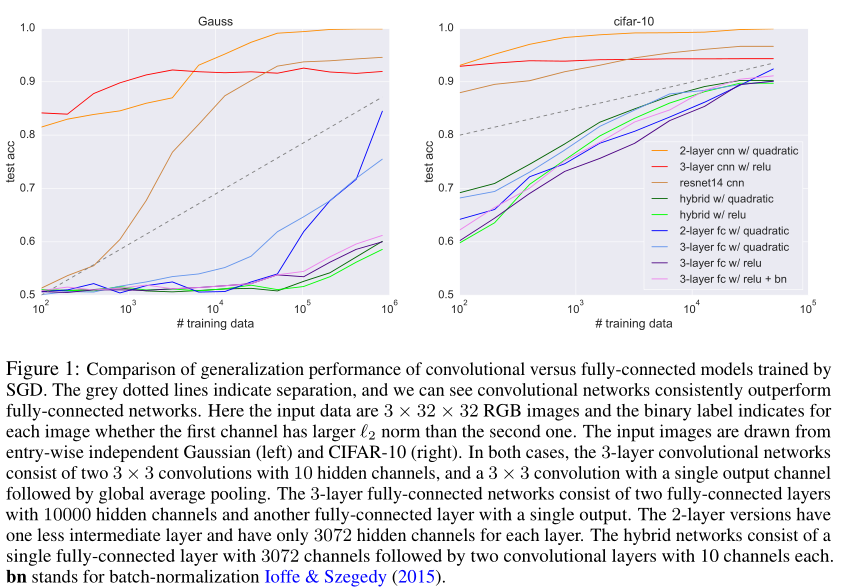

## 1. Methods

The original paper somewhat underspecifies their methods, so we mark in **bold** our assumptions and intepretations.

### Data

The inputs are $3\times8\times8$ RGB images. We will use training sets of increasing sizes $10^2,10^3,\dots,10^5$ and **test sets of size 10'000**. The training sets are constructed in the following manner.

+ Entry-wise independent Gaussian (mean 0, standard deviation 1)

The labels are binary, indicating whether the Red channel has larger $l_2$-norm than the Green channel. Mathematically, the label of an image $x$ is $\mathbb{1}[\sum_{i\in R}x_i^2 > \sum_{i\in G}x_i^2]$. As such, the Blue channel has no effect on the true label. 

### Models
1. 2-layer CNN. **IMPORTANT Comment** - *The CNN architecture as described in Figure 1 does not learn at all - I believe they neglected to mention a final fully connected layer.*
    + Input: Three input channels of size 8x8
    + **Convolution: One kernel per input channel of size 3x3, 10 output channels, stride size 1, and padding of 1, and bias**
    + Activation function
    + **Pooling: Max pooling, kernel size 2x2, stride 2**
    + **Flattening**
    + **Fully connected layer (160 in, 1 out) with bias**
    + **Sigmoid**  
2. 2-layer FCNN 
    + Fully connected layer (192 in, 3072 out) **with bias**
    + Activation function 
    + Fully connected layer (3072 in, 1 out) **with bias**
    + **Sigmoid**
    
For both models, we try both ReLU and Quadratic activation functions (in the convolutional, and hidden layer respectively). 
    
### Training algorithm
+ Stochastic Gradient Descent **with batch size 64**
+ **BCELoss**
+ **Learning rate** $\gamma = 0.01$
+ **Stopping criterion:** **At least 10 epochs AND Training loss < 0.01 AND Rolling avg. of rel. change in training loss < 0.01 (window size 10). OR 500 epochs**.

### Model Evaluation
+ The model $M$ prediction is $\mathbb{1}[M(x)>0.5]$. Test accuracy is the percentage of correct predictions over the test set.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from json import load, dump

# Local python scripts
from helpers import roll_avg_rel_change, calc_label, numel
from models import CNN, FCNN, Quadratic

In [2]:
# Seed random number generation
torch.manual_seed(0)
np.random.seed(0)

In [18]:
# Global constants
learning_rate = 0.01
batch_size = 64
max_epochs = 500
window = 10 # Window size for convergence crit.
rel_conv_crit = 0.01
abs_conv_crit = 0.01

# Input shape
channels = 3 # RGB images
img_size = 8 # Image size length
input_shape = (channels, img_size, img_size)
input_size = img_size * img_size * 3

In [19]:
CNNreLU, CNNquad = CNN(input_shape, nn.ReLU()), CNN(input_shape, Quadratic())
FCNNreLU, FCNNquad = FCNN(input_size, nn.ReLU()), FCNN(input_size, Quadratic())
models = [CNNreLU, CNNquad, FCNNreLU, FCNNquad]
# Print summaries
for model in models:
    summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 10, 8, 8]             280
              ReLU-2             [-1, 10, 8, 8]               0
         MaxPool2d-3             [-1, 10, 4, 4]               0
            Linear-4                    [-1, 1]             161
           Sigmoid-5                    [-1, 1]               0
Total params: 441
Trainable params: 441
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 10, 8, 8]             280
         Quadratic-2             [-1, 10, 8, 8]  

In [16]:
# Data size
N_tr = 10000
N_te = 10000

# Full training and test setas
gauss_x_tr = torch.tensor(np.random.normal(0,1,size=(N_tr,*input_shape)),dtype=torch.float32)
gauss_x_te = torch.tensor(np.random.normal(0,1,size=(N_te,*input_shape)),dtype=torch.float32)

# Full h1 training and test labels (Replace with p=1 for h1)
gauss_y_tr = calc_label(gauss_x_tr, p=2)
gauss_y_te = calc_label(gauss_x_te, p=2)

# Train models on various input sizes
for N in np.vectorize(int)(np.array(np.logspace(2, 4, 10))):
    
    print(f"Training set size: {N}")
    
    # Models
    CNNreLU, CNNquad = CNN(input_shape, nn.ReLU()), CNN(input_shape, Quadratic())
    FCNNreLU, FCNNquad = FCNN(input_size, nn.ReLU()), FCNN(input_size, Quadratic())
    models = [CNNreLU, CNNquad, FCNNreLU, FCNNquad]
    names = ["2-CNN+ReLU", "2-CNN+Quad","2-FCNN+ReLU","2-FCNN+Quad"]
    
    # Optimizers
    optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in models]
    criterion = nn.BCELoss()
    
    # Create a DataLoader for dataset
    dataset = TensorDataset(gauss_x_tr[:N], gauss_y_tr[:N])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for i, model in enumerate(models):
        optimizer = optimizers[i]
        model.train()
        epoch = 0
        converged = False
        queue = []
        while not converged:
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()

                # Is it converged?
                roll_avg = roll_avg_rel_change(queue, window, loss.item())
                if (roll_avg and roll_avg < rel_conv_crit and loss < abs_conv_crit) or epoch == max_epochs:
                    converged = True
                    break

            epoch+=1
        
        print(names[i], "finished. \tEpoch:", epoch,"\tLoss: %.2f" % loss.item(), "\tRoll: %.2f" % roll_avg)

    # Evaluate models
    test_loss = [0 for i in range(len(models))]
    accuracy = [0 for i in range(len(models))]
    
    with torch.no_grad():
        for i, model in enumerate(models):
            model.eval()
            out = model(gauss_x_te)
            test_loss[i] += criterion(out, gauss_y_te)
            accuracy[i] += float(sum(torch.eq((out>0.5).to(float),gauss_y_te))/N_te)

    # Read the JSON file
    file_path = 'test_acc.json'
    with open(file_path, 'r') as json_file:
        test_acc = load(json_file)

    # Add experiment to results
    test_acc[str(N)]=accuracy

    # Write accuracy to file
    with open(file_path, 'w') as json_file:
        dump(test_acc, json_file)

Training set size: 100
2-CNN+ReLU finished. 	Epoch: 501 	Loss: 0.64 	Roll: 0.03
2-CNN+Quad finished. 	Epoch: 501 	Loss: 0.50 	Roll: 0.06
2-FCNN+ReLU finished. 	Epoch: 501 	Loss: 0.28 	Roll: 0.04
2-FCNN+Quad finished. 	Epoch: 501 	Loss: 0.13 	Roll: 0.04
Training set size: 166
2-CNN+ReLU finished. 	Epoch: 501 	Loss: 0.65 	Roll: 0.03
2-CNN+Quad finished. 	Epoch: 501 	Loss: 0.51 	Roll: 0.06
2-FCNN+ReLU finished. 	Epoch: 501 	Loss: 0.31 	Roll: 0.07
2-FCNN+Quad finished. 	Epoch: 501 	Loss: 0.12 	Roll: 0.06
Training set size: 278
2-CNN+ReLU finished. 	Epoch: 501 	Loss: 0.65 	Roll: 0.03
2-CNN+Quad finished. 	Epoch: 501 	Loss: 0.50 	Roll: 0.06
2-FCNN+ReLU finished. 	Epoch: 501 	Loss: 0.32 	Roll: 0.08
2-FCNN+Quad finished. 	Epoch: 501 	Loss: 0.12 	Roll: 0.04
Training set size: 464
2-CNN+ReLU finished. 	Epoch: 501 	Loss: 0.65 	Roll: 0.02
2-CNN+Quad finished. 	Epoch: 501 	Loss: 0.55 	Roll: 0.08


KeyboardInterrupt: 

### Experiment notes
+ Since I am running on my private laptop I have reduced the synthetic data to 3x8x8. 
    + Update 20/09 I have since been able to access the compute cluster at the lab.
+ I was **unable** to get the CNNs to learn with the architecture described in figure 1
    + conv1 (3, 10) -> conv2 (10,1) -> global average pooling -> sigmoid
    + Update 20/09 I will try this again.
+ I **was** able to get the CNNs to learn with an instance of the theoretical architecture described in section 3.1
    + conv (3, 10) -> activation -> max pooling -> fc (160, 1) -> sigmoid
+ I have not tried learning with the labels over with CIFAR-10 because of the image size.
+ I have sent an email to Zhiyuan and Yi to request their code but I have not yet received an answer as of 20/09. 

### Results

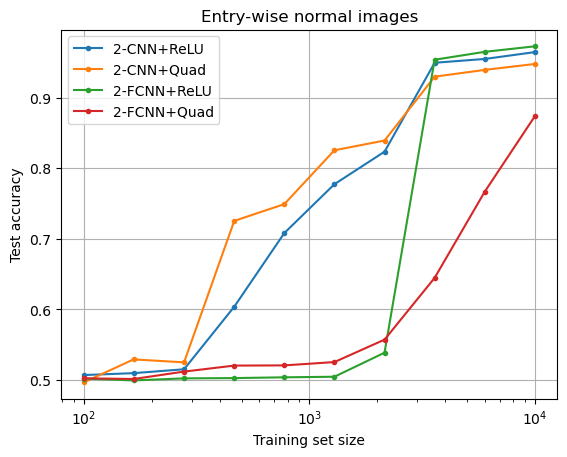

In [17]:
import matplotlib.pyplot as plt

# Load data
file_path = 'test_acc.json'
with open(file_path, 'r') as json_file:
    test_acc = load(json_file)

# Create sorted dictionary out of saved data
new_dict = {}
for key in test_acc.keys():
    new_dict[int(key)]=test_acc[key]
sorted_dict = dict(sorted(new_dict.items()))

# Convert the dictionary to a format suitable for plotting
x_values = np.sort([int(key) for key in sorted_dict.keys()])  # Convert keys to integers

# For every model, make line plot
for i, model in enumerate(models):
    
    # The accuracy values for increasing number of samples
    y_values = [value[i] for value in sorted_dict.values()]

    # Create a line plot
    plt.semilogx(x_values, y_values, marker='.', linestyle='-', label=names[i])
    
# Plot graphics
plt.xlabel('Training set size')
plt.ylabel('Test accuracy')
plt.title('Entry-wise normal images')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## References
1. [Why Are Convolutional Nets More Sample-Efficient than Fully-Connected Nets?](https://arxiv.org/abs/2010.08515) Zhiyuan Li, Yi Zhang, Sanjeev Arora, 2021
2. [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.